# Fluorescence polarization

In [1]:
from io import StringIO
from pathlib import Path
from itertools import repeat
from collections import namedtuple

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

## Polarization

In [2]:
folder = Path('data/fluorescence-polarization') # specify path to your data

In [3]:
def read(csv_file: Path):
    content = csv_file.read_text()
    data = content.partition('\n\n')[0]
    file = StringIO(data)
    df = pd.read_csv(file, skiprows=2,
                     names=['wavelength', 'intensity'], usecols=[0, 1])
    return df

In [4]:
def get_data(folder: Path):
    d = {}
    for p in folder.glob('*.csv'):
        d[p.stem] = read(p)
    return pd.Series(d)

In [5]:
all_data = get_data(folder).sort_index()

## Curve fitting

In [6]:
def peak(x: np.array, A=1, mu=0, sigma=1):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

In [7]:
def objective(x, *params):
    params = np.array(params).flatten()
    shape = int(len(params) / 3), 3
    peaks = np.reshape(params, shape)
    return sum(peak(x, A, mu, sigma) for A, mu, sigma in peaks)

In [8]:
def fit_peaks(sr: pd.Series, mus, range=None, internal_sample=100):

    x = sr.index
    y = sr.values
    inits = zip(repeat(1), mus, repeat(1))
    p0 = [p for z in inits for p in z] # flattenize

    popt, pcov = curve_fit(objective, x, y, p0=p0)
    return np.split(popt, len(popt) / 3)

## Plot

In [9]:
def peak_analysis(all_data):

    fig, axs = plt.subplots(6, 4,
                            sharex=True, sharey=True,
                            figsize=(10, 10)
    )

    Z = zip(
        range(1, len(all_data) + 1),
        all_data.items(),
        axs.ravel()
    )

    intensities = {}
    peaks = {}

    for i, (k, data), ax in Z:

        # find main peak
        data.plot(x=0, y=1, ax=ax)

        smooth = gaussian_filter1d(data.intensity, 2) # smoothing factor
        [peak_idx], _ = find_peaks(smooth) # should be only 1 peak, increase smoothing factor
        data.iloc[[peak_idx]].plot(x=0, y=1, style='.r', ax=ax)
        wl, int_ = data.iloc[peak_idx]

        title = '№ {no} : $\lambda = {wl:.0f}$, $I_{{{idxs}}} = {int:.2f}$'.format(
            no=k[0], wl=wl,
            idxs=','.join(k[1:]), int=int_
        )

        ax.set_title(title)
        ax.get_legend().remove()

        intensities[(k[0], k[1:])] = int_
        

        # peak decomposition
        sr = data.set_index('wavelength').intensity
        minmax = sr.index.min(), sr.index.max()

        sr.plot(ax=ax)
        x = np.linspace(*minmax, 1000)

        pks = fit_peaks(sr, [500, 540]) # adjust wavelength
        peaks[(k[0], k[1:])] = pks
        ax.plot(x, objective(x, *pks), 'r', alpha=0.5)
        [ax.plot(x, peak(x, *parms), '--', alpha=0.5) for parms in pks];


    plt.tight_layout()

    yield pd.Series(intensities).unstack(level=1) # intensities

    tpl = namedtuple('Peak', ['A', 'mu', 'sigma'])
    yield pd.DataFrame({ k: tpl(*pk) for k, pks in peaks.items() for pk in pks })\
        .set_index(pd.Index(['A', 'mu', 'sigma'])).T # peaks

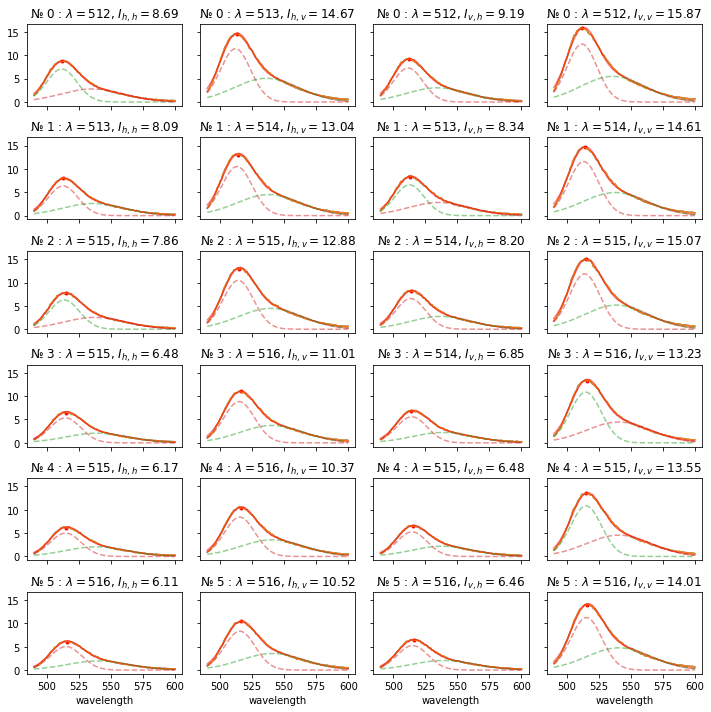

In [10]:
intensities, peaks = peak_analysis(all_data)

In [11]:
intensities['g_factor'] = intensities.hv / intensities.hh
intensities['polarization'] = intensities.apply(
    lambda x: (x.vv - x.g_factor * x.vh) / (x.vv + x.g_factor * x.vh),
    axis=1
)

In [12]:
intensities

,hh,hv,vh,vv,g_factor,polarization
0,8.692522,14.668288,9.187510,15.867807,1.687461,0.011611
1,8.085460,13.035077,8.340162,14.611181,1.612163,0.041540
2,7.856707,12.878545,8.202553,15.067453,1.639178,0.056887
3,6.478344,11.011899,6.853699,13.229930,1.699802,0.063505
4,6.167875,10.369456,6.478917,13.547698,1.681204,0.108646
5,6.111468,10.518697,6.460008,14.011591,1.721141,0.115121


In [13]:
peaks

A          mu      sigma
0 hh  171.207778  535.324647  24.542726
  hv  337.168043  512.053716  11.786603
  vh  211.027115  511.513513  11.565836
  vv  364.241755  511.992314  11.717146
1 hh  185.545447  512.742981  11.641281
  hv  314.189148  513.232314  11.925300
  vh  169.243490  535.584686  24.002905
  vv  344.185936  513.270031  11.848639
2 hh  154.788549  537.636525  24.335133
  hv  312.865764  514.210419  11.934084
  vh  191.994157  513.526196  11.659337
  vv  355.750216  514.092660  11.973688
3 hh  161.279764  514.535823  12.015150
  hv  266.280281  514.923531  12.035761
  vh  167.283368  514.407662  11.952260
  vv  281.278767  540.613616  25.109393
4 hh  150.594801  514.659390  11.976600
  hv  253.136911  515.309895  11.988821
  vh  154.845512  514.580871  11.747674
  vv  287.612671  540.593231  25.106835
5 hh  153.034928  515.070423  12.110722
  hv  250.650706  515.419967  12.015015
  vh  159.080661  515.058931  12.084276
  vv  341.024340  515.418936  12.086628